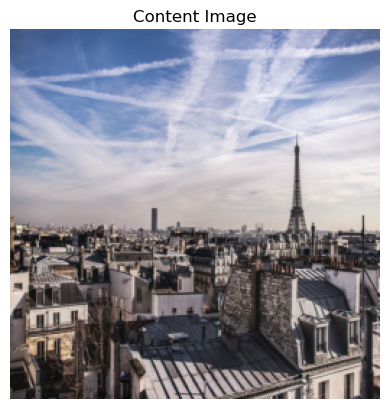

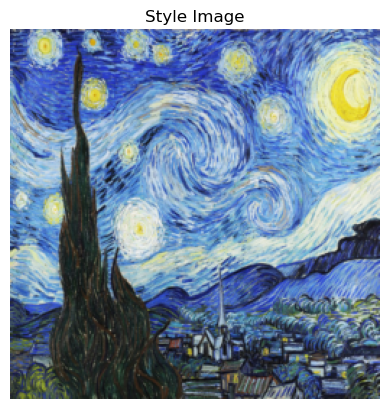

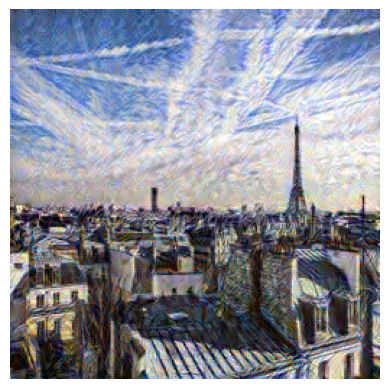

In [7]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess image
def load_image(img_path, size=256):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# Gram matrix calculation
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    return torch.mm(features, features.t()) / (c * h * w)

# Feature extraction using MobileNetV2
class FeatureExtractor(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.model = models.mobilenet_v2(pretrained=True).features
        self.layers = layers

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.model):
            x = layer(x)
            if str(i) in self.layers:
                features.append(x)
        return features

# Load images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = load_image('base.jpg').to(device)
style = load_image('style.jpg').to(device)
target = content.clone().requires_grad_(True)


def imshow(tensor, title):
    img = tensor.squeeze().cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

imshow(content, "Content Image")
imshow(style, "Style Image")

# Extract features
extractor = FeatureExtractor(layers=['4', '7']).to(device).eval()

with torch.no_grad():
    style_features = extractor(style)
    content_features = extractor(content)

style_grams = [gram_matrix(f).detach() for f in style_features]

# Optimizer
optimizer = torch.optim.Adam([target], lr=0.01)

# Style Transfer loop
for step in range(200):
    target_features = extractor(target)
    content_loss = F.mse_loss(target_features[-1], content_features[-1])
    style_loss = sum(F.mse_loss(gram_matrix(f), g) for f, g in zip(target_features, style_grams))
    loss = content_loss + 1e5 * style_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Display output
output = target.squeeze().detach().cpu().clamp(0, 1).permute(1, 2, 0)
plt.imshow(output)
plt.axis('off')
plt.show()
